# AI-Generated Image Detection

Generative artificial intelligence (GenAI) has evolved rapidly within the last few years.
A central achievement is the ability to generate highly-realistic images from a simple text prompt.
While this technology can support us in productive and creative tasks, it also holds great potential for misuse.
AI-generated images are increasingly being used to commit fraud and spread harmful disinformation.

In this assignment, we will take a closer look at the internals of a generative model and create our own images.
Then, we will exploit the model's architecture to detect AI-generated images using [AEROBLADE](https://arxiv.org/abs/2401.17879).

**Note:** If your local setup does not have a GPU, it is highly recommended to run this notebook on Google Colab (see this repository's README for instructions).

In [ ]:
# if you are running this notebook on Google Colab, uncomment and run the following commands

# !pip install lpips --no-deps
# !mkdir data
# !wget https://github.com/aisoc-lab/ai-security-summer-school/blob/6df293b9cb46bddda293237af74b592457219c88/tutorial_03_deepfakes/data/real_elephant.jpg?raw=True -O data/real_elephant.jpg
# !wget https://github.com/aisoc-lab/ai-security-summer-school/blob/6df293b9cb46bddda293237af74b592457219c88/tutorial_03_deepfakes/data/fake_elephant.png?raw=True -O data/fake_elephant.png

In [16]:
import lpips
import matplotlib.pyplot as plt
import numpy as np
import torch
from diffusers import AutoPipelineForText2Image
from diffusers.utils import make_image_grid, pt_to_pil
from PIL import Image
from torchvision.transforms.functional import to_tensor

## Generating Images Using Stable Diffusion XL Turbo

The seminal work by [Rombach et al.](https://arxiv.org/abs/2112.10752), which sparked the development of [Stable Diffusion](https://github.com/CompVis/stable-diffusion) marks a milestone in text-to-image synthesis.
In this assignment, we will be working with its successor [Stable Diffusion XL Turbo](https://arxiv.org/abs/2307.01952), which allows for the generation of highly-realistic images within a single step.

A convenient way to use diffusion models is the [diffusers](https://huggingface.co/docs/diffusers/index) library.
In the following, we create a *pipeline* from the pre-trained SDXL-Turbo model.

In [17]:
pipeline = AutoPipelineForText2Image.from_pretrained(
    "stabilityai/sdxl-turbo", torch_dtype=torch.float16, variant="fp16"
)

# performance tweaks
pipeline.enable_sequential_cpu_offload()
pipeline.upcast_vae()

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

We can now take a look at the model's architecture by simply printing the pipeline.
It mostly resembles that of the original Stable Diffusion and features a U-Net, a text encoder, and a variational autoencoder (VAE).
The VAE is used to transform an image to the latent space, in which the actual generation takes place, and back.
It will be important later, since it can be leveraged to determine whether an image is real or AI-generated.

<center>
<img src="https://github.com/aisoc-lab/ai-security-summer-school/blob/6df293b9cb46bddda293237af74b592457219c88/tutorial_03_deepfakes/data/stable-diffusion-architecture.png?raw=true" alt="Architecture of Stable Diffusion" width="600"/>

*Source: [https://arxiv.org/abs/2112.10752](https://arxiv.org/abs/2112.10752).*
</center>

In [18]:
pipeline

StableDiffusionXLPipeline {
  "_class_name": "StableDiffusionXLPipeline",
  "_diffusers_version": "0.33.1",
  "_name_or_path": "stabilityai/sdxl-turbo",
  "feature_extractor": [
    null,
    null
  ],
  "force_zeros_for_empty_prompt": true,
  "image_encoder": [
    null,
    null
  ],
  "scheduler": [
    "diffusers",
    "EulerAncestralDiscreteScheduler"
  ],
  "text_encoder": [
    "transformers",
    "CLIPTextModel"
  ],
  "text_encoder_2": [
    "transformers",
    "CLIPTextModelWithProjection"
  ],
  "tokenizer": [
    "transformers",
    "CLIPTokenizer"
  ],
  "tokenizer_2": [
    "transformers",
    "CLIPTokenizer"
  ],
  "unet": [
    "diffusers",
    "UNet2DConditionModel"
  ],
  "vae": [
    "diffusers",
    "AutoencoderKL"
  ]
}

With diffusers, generating an image is straightforward: call the pipeline with your prompt and some additional parameters and wait for the result.
Enter a prompt below and generate some images!

While the guidance scale should be set to 0.0, you can vary the number of inference steps.
Values of 2, 3, or 4 should yield better image quality at the cost of longer runtime.

  0%|          | 0/1 [00:00<?, ?it/s]

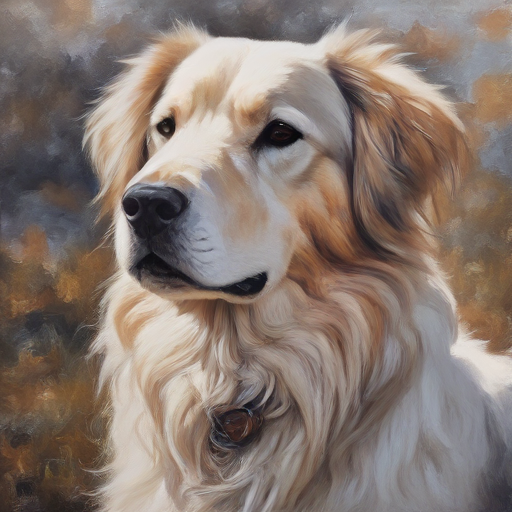

In [19]:
# prompt = # Your prompt here
# img = pipeline(prompt=prompt, guidance_scale=0.0, num_inference_steps=1).images[0]
# img

# solution
prompt = "a painting of a majestic dog"
img = pipeline(prompt=prompt, guidance_scale=0.0, num_inference_steps=1).images[0]
img

# Using the VAE

We can now use the VAE to transform our generated image into the model's latent space.
To do so, we need to first apply some pre-processing.
Then, we can call the VAE's `encode` method on our image.
Since a VAE outputs a distribution, we need to sample from it to obtain the actual latents.

In [20]:
with torch.no_grad():  # avoid gradient computation
    preprocessed_img = pipeline.image_processor.preprocess(img)
    latents = pipeline.vae.encode(preprocessed_img).latent_dist.sample()

You can now have a look at the latents.

First, inspect their dimensions.
How do they differ from those of the image?

Second, visualize the latents. You can make use of the `plot_tensor` function defined below. Since the channels in the latent space do not directly map to color channels, you should plot each channel independently.

In [21]:
def plot_tensor(tensor: torch.Tensor, vmin: float | None = None, vmax: float | None = None) -> None:
    """
    Plot a tensor using matplotlib's imshow. Optionally resize tensor and change minimum/maximum value for better visualization.
    """
    # move channel dimension to the end and normalize
    if tensor.ndim == 3 and tensor.shape[0] == 3:
        tensor = tensor.permute(1, 2, 0)
    plt.imshow(tensor.numpy(), vmin=vmin, vmax=vmax)
    plt.colorbar()
    plt.show()

torch.Size([1, 4, 64, 64])


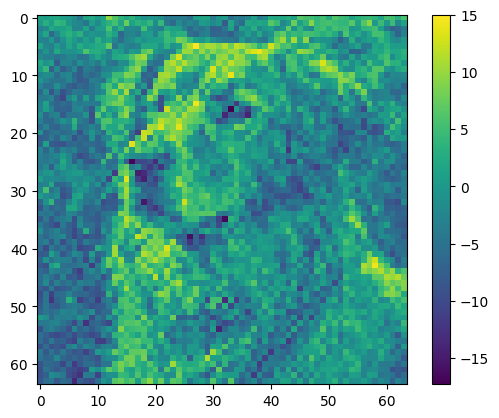

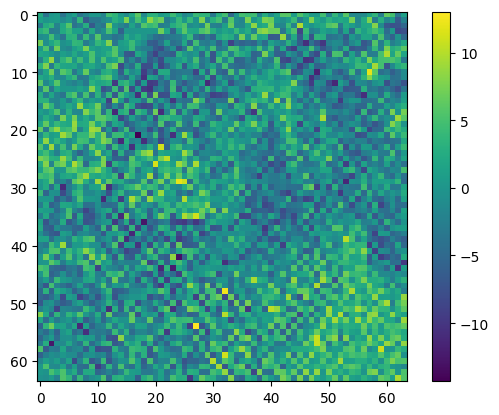

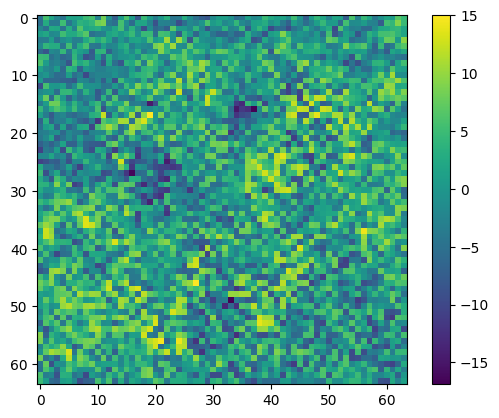

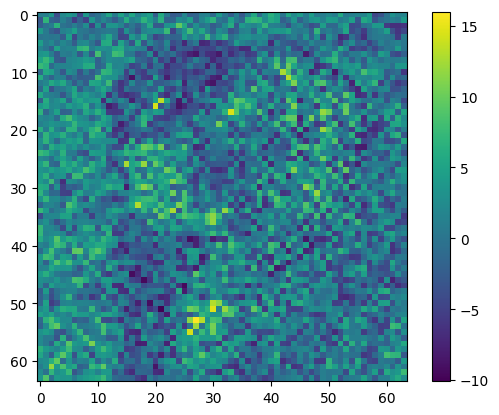

In [22]:
# Your code here

# solution
print(latents.shape)

for channel in latents[0]:
    plot_tensor(channel.cpu())

Using the VAE's decoder, we can now reconstructe the original image from the latents.
Try this on your own. Basically, you need to reverse the steps we took to encode an image, so first call the VAE's `decode` method and then apply post-processing using the `postprocess` method of the `image_processor`.

**Note:** Due to model internals, you need to change the data type of the VAE to `float32` before calling its decode method. This can be done using `pipeline.vae.to(dtype=torch.float32)`. Moreover, the `decode` function returns a data structure. You can access the actual sample using `.sample`.

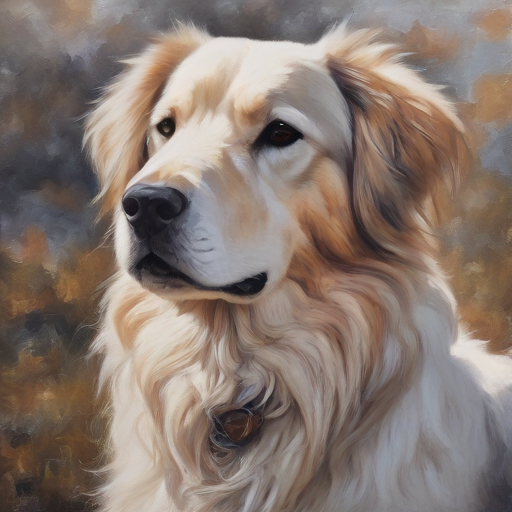

In [23]:
# Your code here

# solution
with torch.no_grad():
    pipeline.vae.to(dtype=torch.float32)
    reconstruction = pipeline.vae.decode(latents).sample
    reconstruction = pipeline.image_processor.postprocess(reconstruction)[0]
reconstruction

While the original image and its reconstruction look identical, they are not.
Since the latent space is significantly smaller than the image space (to speed up generation), it cannot preserve every detail of an image.

To show this, compute the absolute error between original and reconstruction and visualize the average error across all color channels.
The `to_tensor` function might come in handy here.

Have a look at what parts of the image can be reconstructed well, and what parts suffer from larger reconstruction errors.

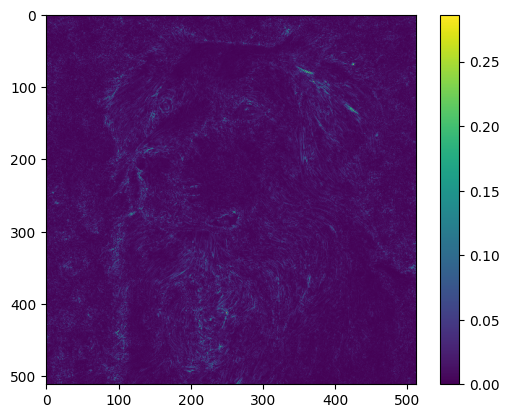

In [24]:
# Your code here

# solution
absolute_error = abs(to_tensor(img) - to_tensor(reconstruction)).mean(dim=0)
plot_tensor(absolute_error)

## Detecting AI-Generated Images Using AEROBLADE

The previous observation is the core idea of AEROBLADE.
It exploits the fact that generated images can be reconstructed relatively well.
For each generated image, there is a distinct location in the VAE's latent space, which can be seen as its origin.

In contrast, real images do not have an exact origin.
They are mapped to the closest point in the latent space.
Due to this shift, they exhibit a higher reconstruction error.

Thus, if an image can be reconstructed well using a model's VAE, chances are high that it is generated by this particular model.

The following figure further illustrates this idea.
Note that we can use different distance/error metrics for $d$.
Experiments have shown that [LPIPS](https://arxiv.org/abs/1801.03924) performs particularly well.
<center>
<img src="https://github.com/aisoc-lab/ai-security-summer-school/blob/6df293b9cb46bddda293237af74b592457219c88/tutorial_03_deepfakes/data/aeroblade.png?raw=true" alt="Concept behind AEROBLADE" width="600"/>

*Source: [https://arxiv.org/abs/2401.17879](https://arxiv.org/abs/2401.17879).*
</center>

In `data/real_elephant.jpg` and `data/fake_elephant.png` you find two images we can use to demonstrate AEROBLADE.
For both images, apply the steps from above to create their reconstructions.
Then, use the LPIPS metric to compute the distance and visualize it.

You should initialize LPIPS using `lpips_fn = lpips.LPIPS(net="vgg", spatial=True)` and call it with `lpips_fn(..., normalize=True)`.

**Hints:**
- You can use `Image.open("path/to/file")` to load images with PIL.
- LPIPS expects inputs to be 4-dimensional (samples x channels x width x height).
- Using the `vmin`/`vmax` arguments of `plot_tensor` can improve visualization, especially to align the color bars for both images.


Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [on]
Loading model from: /home/rickejsj/.conda/envs/aisec/lib/python3.12/site-packages/lpips/weights/v0.1/vgg.pth


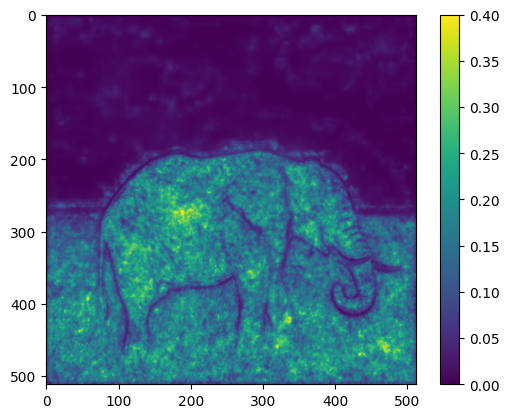

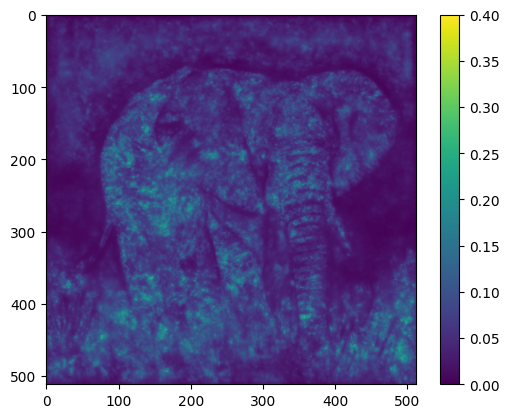

In [25]:
# Your code here

# solution
def compute_reconstruction(img: Image.Image) -> Image.Image:
    with torch.no_grad():
        preprocessed_img = pipeline.image_processor.preprocess(img)
        latents = pipeline.vae.encode(preprocessed_img).latent_dist.sample()
        pipeline.vae.to(dtype=torch.float32)
        reconstruction = pipeline.vae.decode(latents).sample
        reconstruction = pipeline.image_processor.postprocess(reconstruction)[0]
        return reconstruction


real_img = Image.open("data/real_elephant.jpg")
real_rec = compute_reconstruction(real_img)
fake_img = Image.open("data/fake_elephant.png")
fake_rec = compute_reconstruction(fake_img)

with torch.no_grad():
    lpips_fn = lpips.LPIPS(net="vgg", spatial=True)
    real_dist = lpips_fn(to_tensor(real_img).unsqueeze(0), to_tensor(real_rec).unsqueeze(0), normalize=True)[0][0]
    plot_tensor(real_dist, vmin=0, vmax=0.4)
    fake_dist = lpips_fn(to_tensor(fake_img).unsqueeze(0), to_tensor(fake_rec).unsqueeze(0), normalize=True)[0][0]
    plot_tensor(fake_dist, vmin=0, vmax=0.4)

As you can see, the reconstruction error for the real image is significantly larger than that of the fake image.
By taking the spatial average over all pixels, we obtain a single value for simple threshold-based detection of AI-generated images!

**Congratulations, you made it to the end of the notebook!**